# Homework Assignment 7

**Question 1:** Select three books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape, Gephi, or any other Graph Visualization tool (20pt).


2023-05-25 13:40:45.028951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:40:48.047655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
 99% 1.29G/1.30G [00:17<00:00, 37.2MB/s]
100% 1.30G/1.30G [00:17<00:00, 80.7MB/s]
Archive:  10000-books-and-their-genres-standardized.zip
  inflating: books_and_genres.csv    


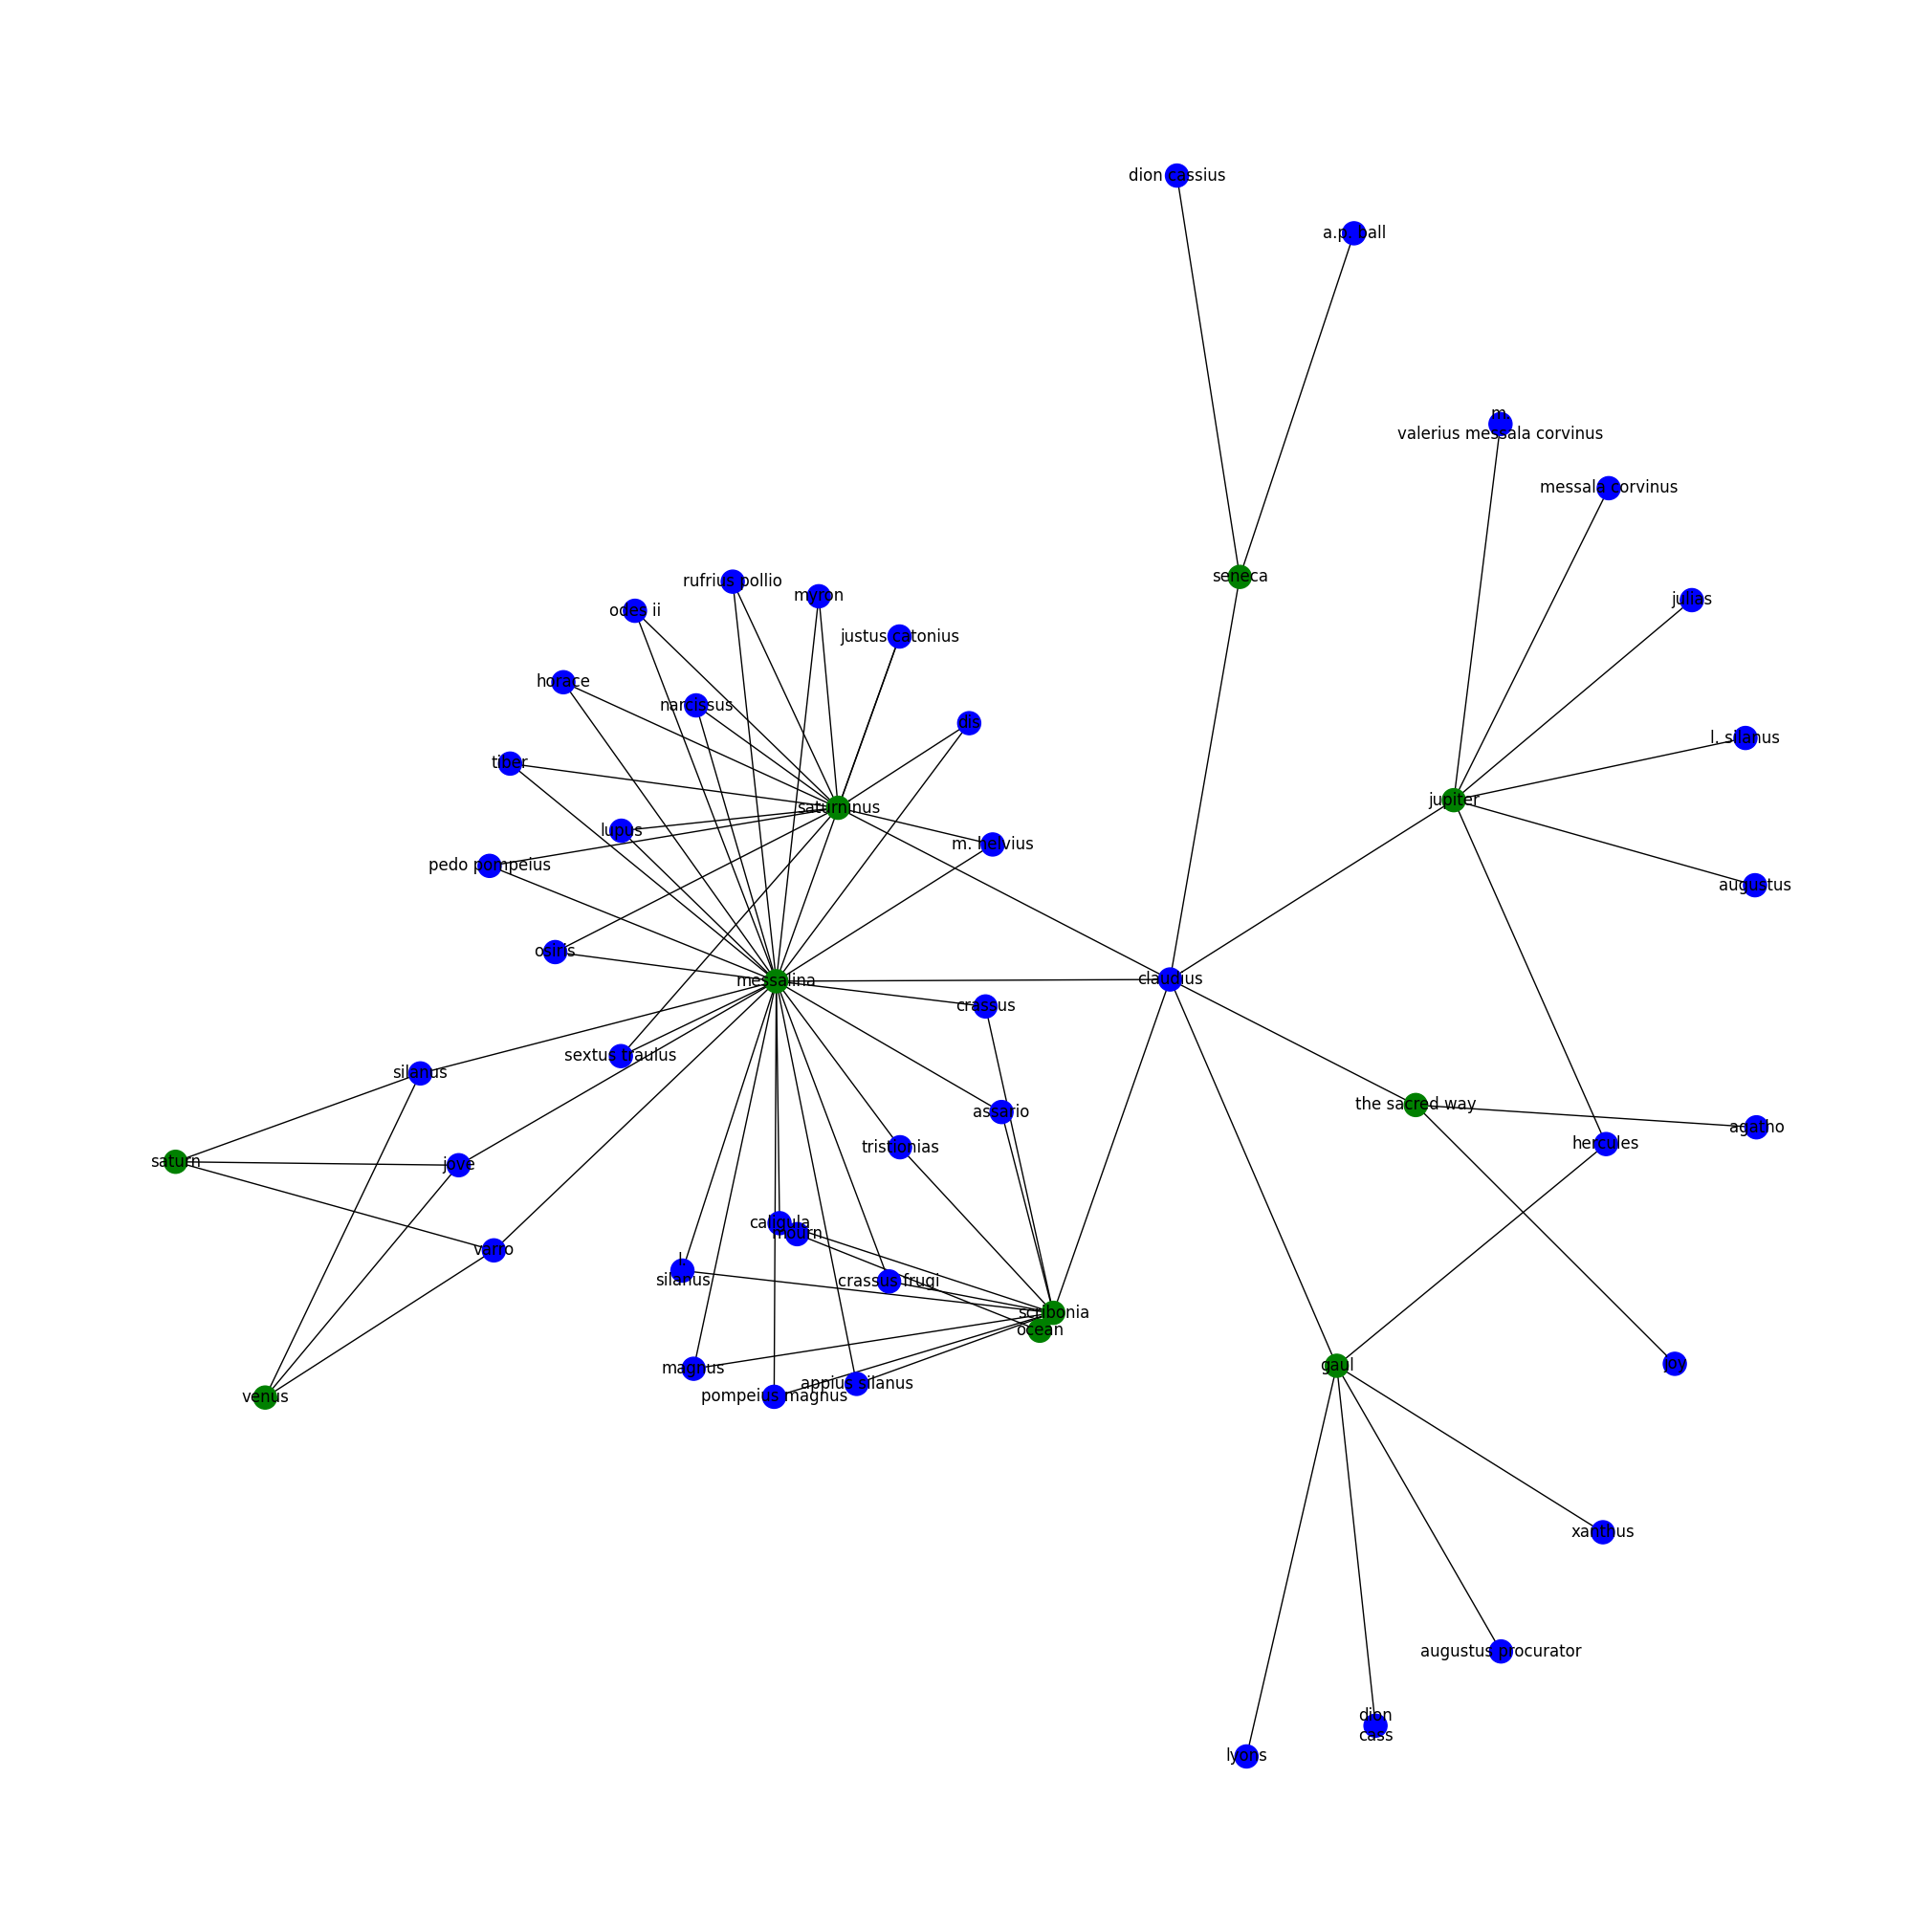

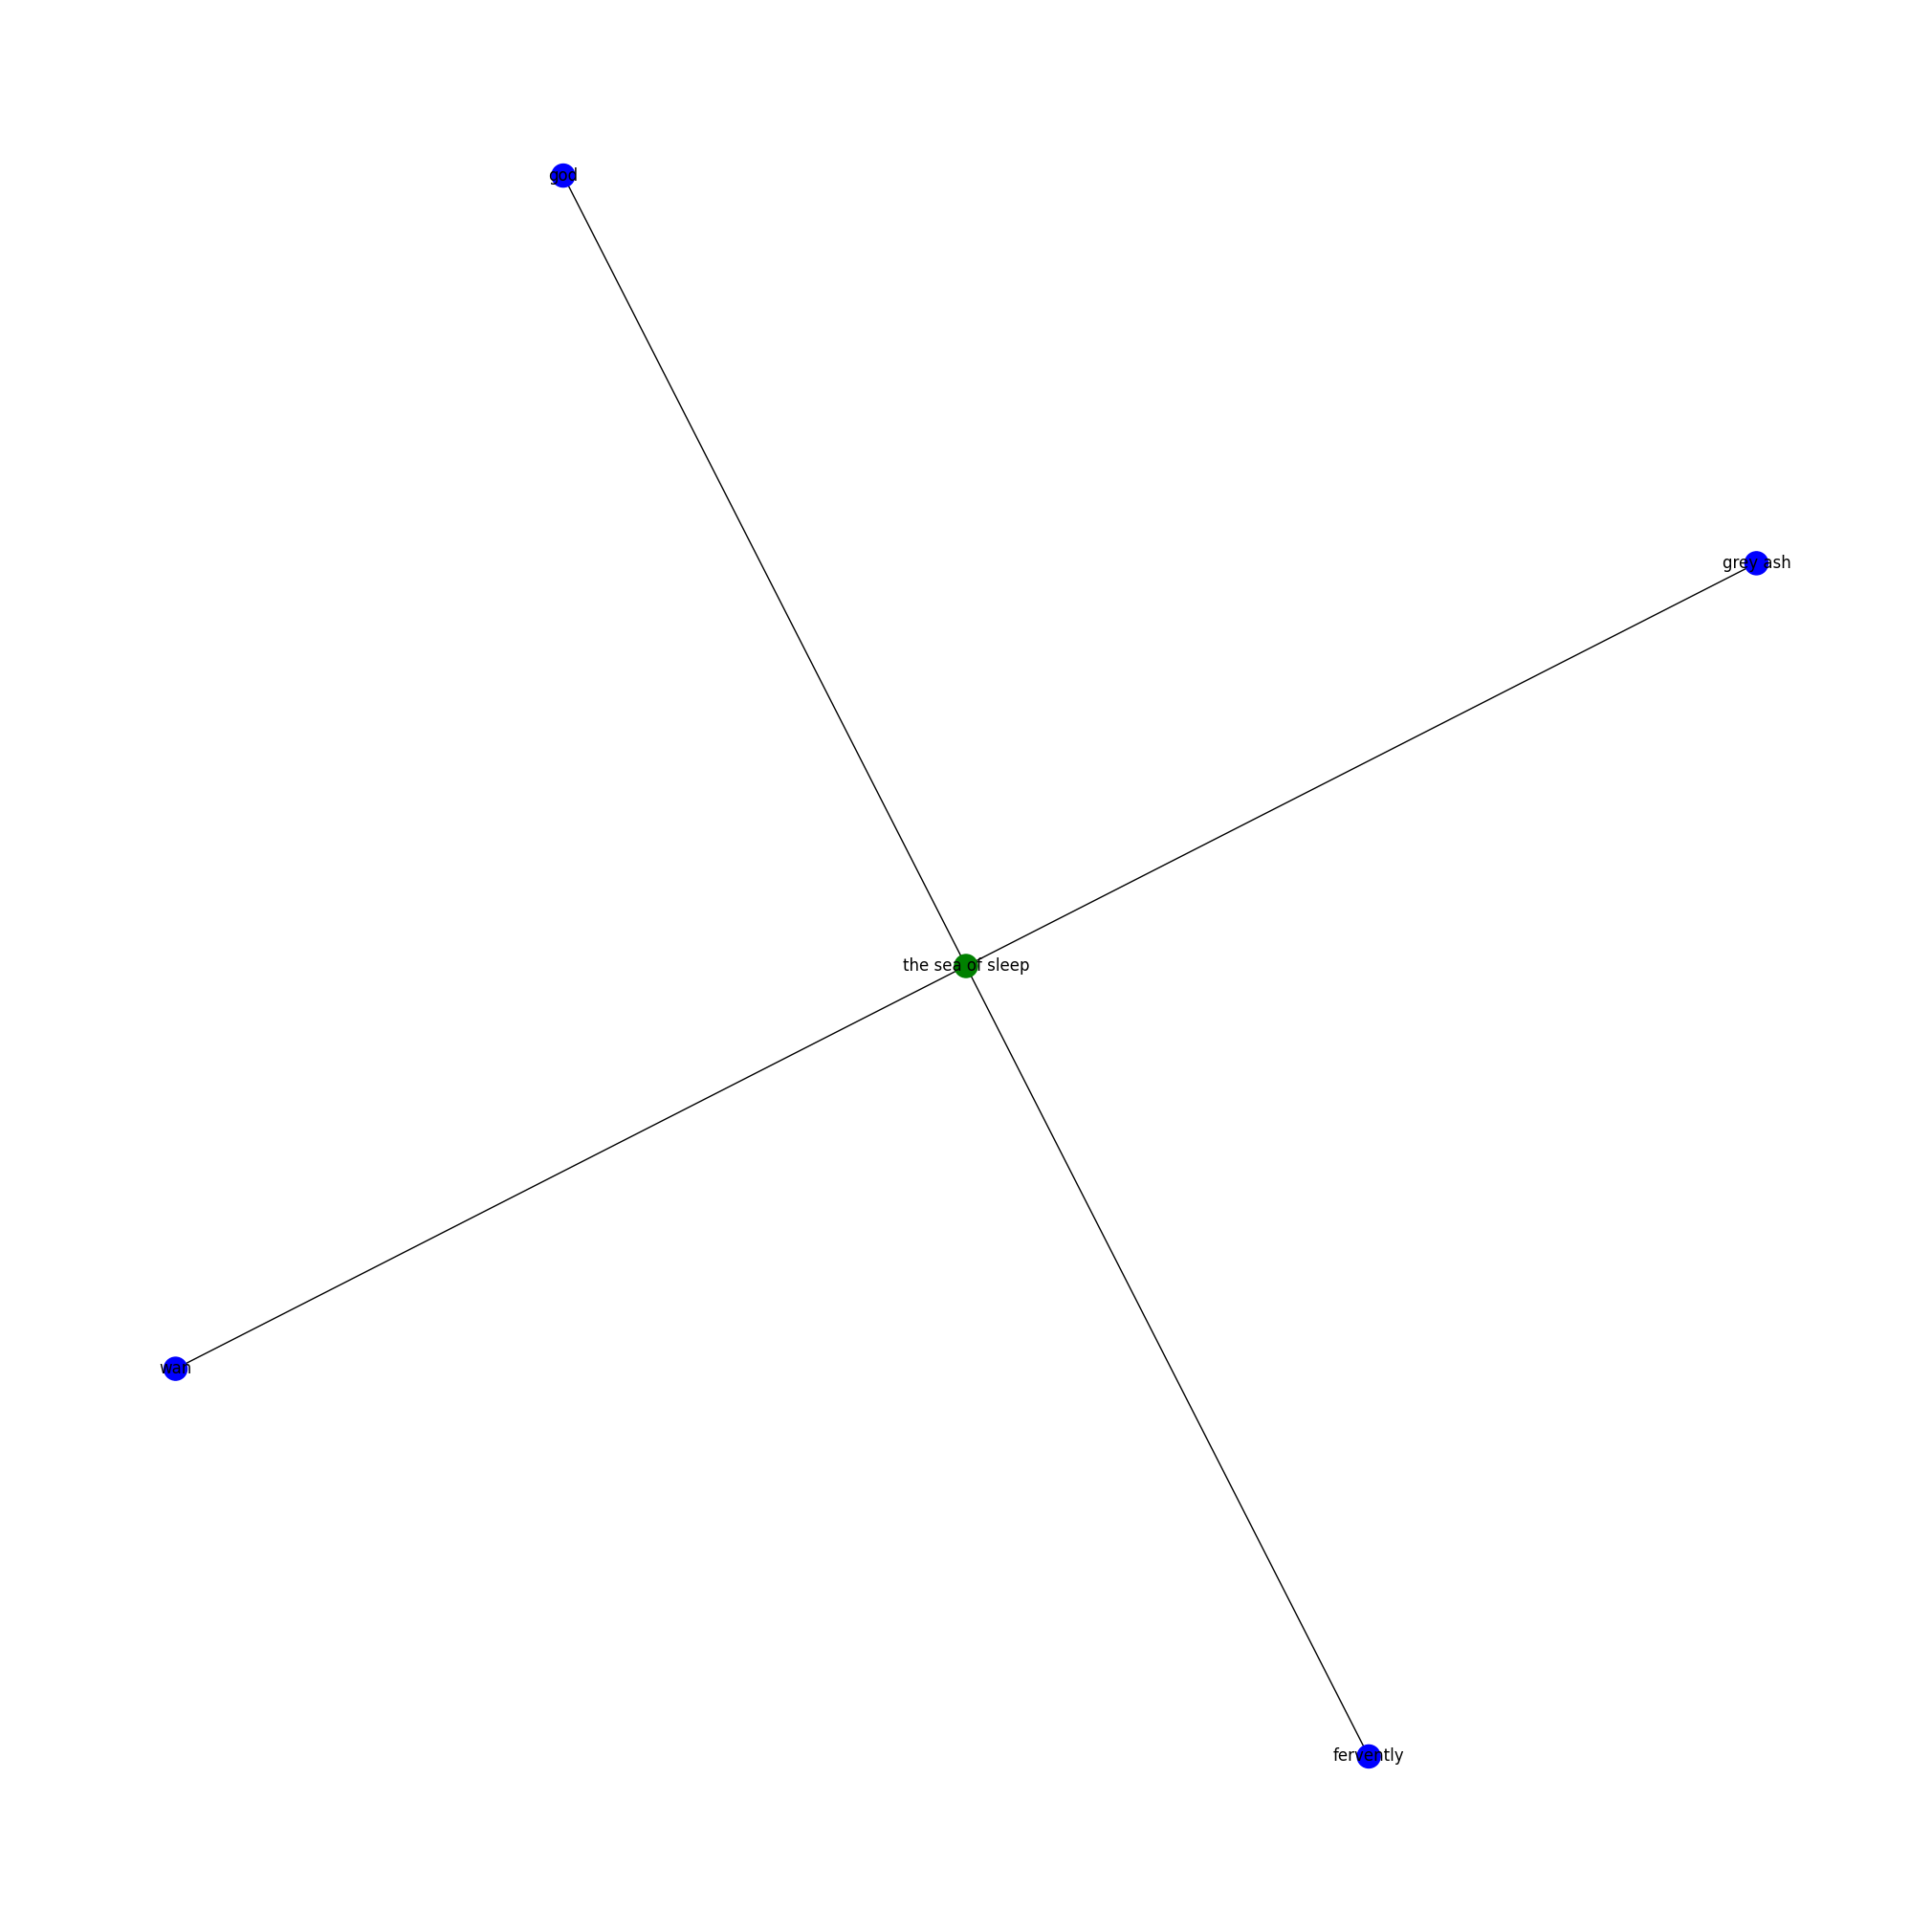

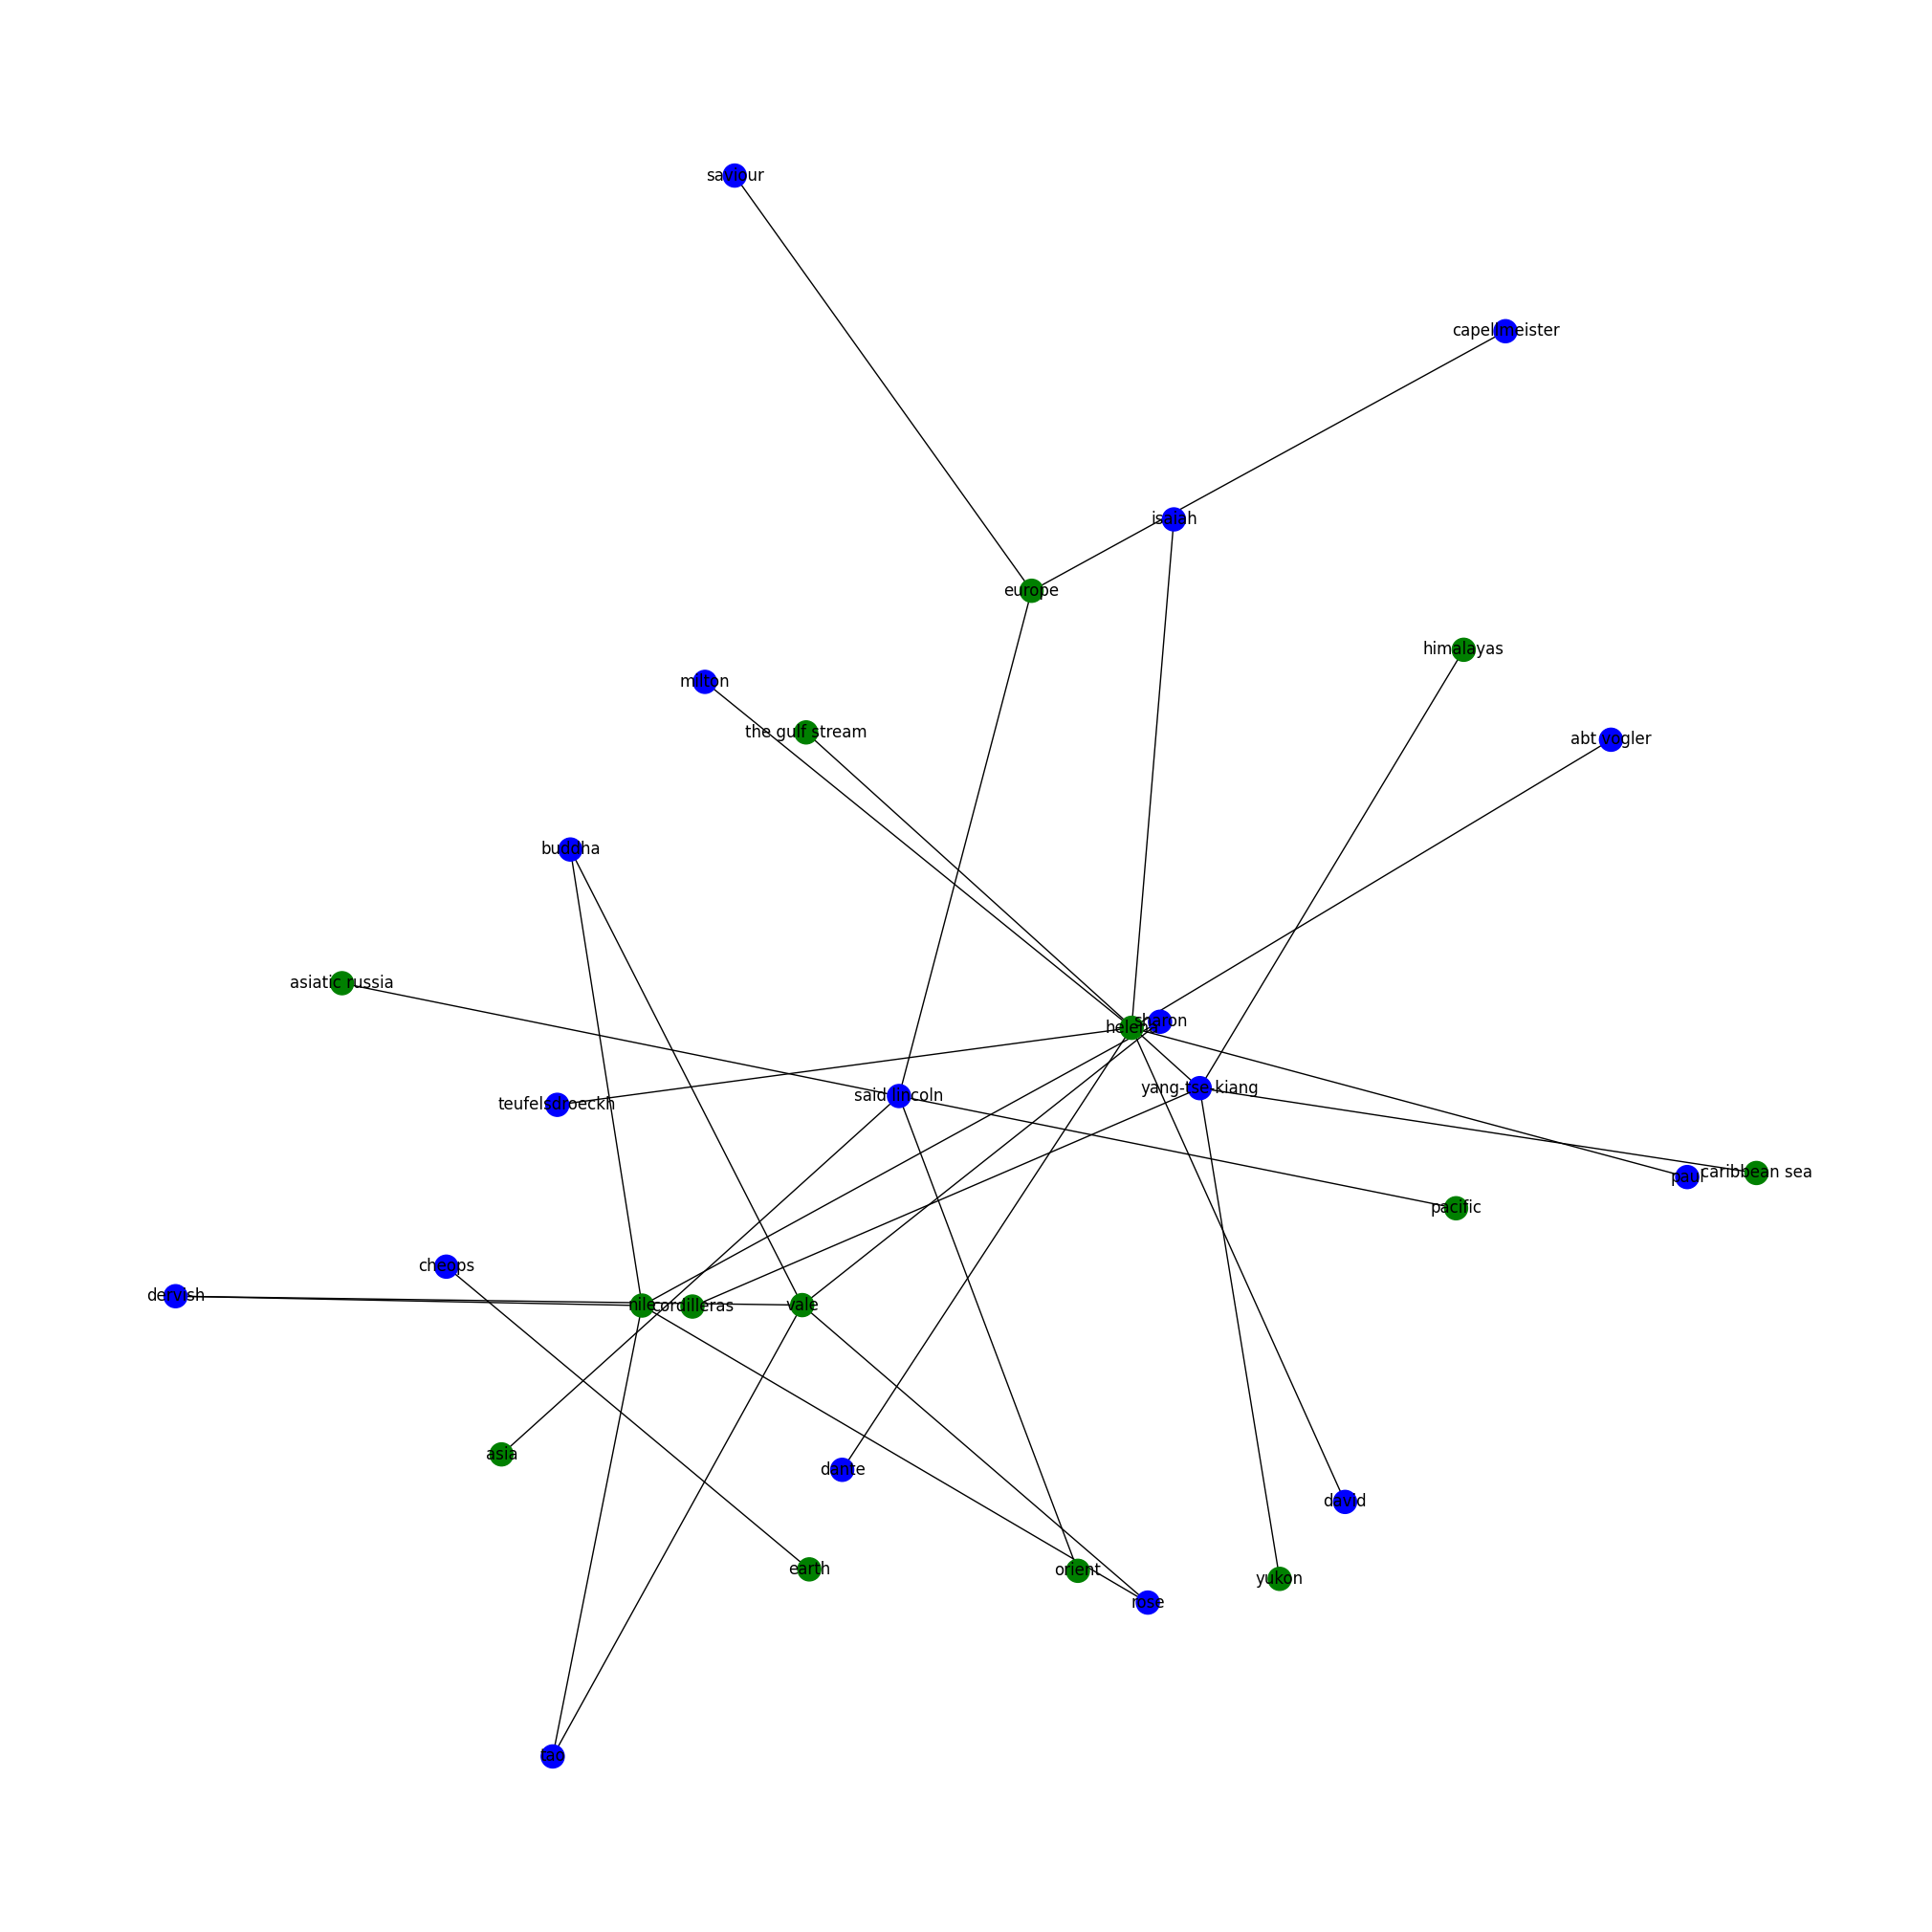

In [1]:
!python -m spacy download en_core_web_lg 


import os
import json
import spacy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt


# Config kaggle
!mkdir /root/.kaggle/
api_token = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# Download data
!kaggle datasets download -d michaelrussell4/10000-books-and-their-genres-standardized
# Unzip data
!unzip -o 10000-books-and-their-genres-standardized.zip
# Get three books
stories_df = pd.read_csv("books_and_genres.csv", nrows = 3)
# load spacy
nlp = spacy.load('en_core_web_lg')
# Method to get entites from text
def get_entites_dict_from_text(text):
    entities_dict= {}
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

# Method to get people and location links from text
def get_person_location_links(txt):
    links_set = set()
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    for e1 in [k.lower() for k,v in d.get("PERSON", {}).items()]:
        for e2 in [k.lower() for k,v in d.get("LOC", {}).items()]:
            links_set.add((e1, e2))
    return links_set

# Meth to creat people and location network from book
def create_person_location_graph(txt):
    links_list = set() 
    for paragraph in txt.split("\n\n"):
        links_list = links_list.union(get_person_location_links(paragraph))
    people = [i[0] for i in links_list]
    color_map = []
    G = nx.from_edgelist(links_list)
    for node in G.nodes():
        if node in people:
            color_map.append('blue')
        else: 
            color_map.append('green') 
    plt.figure(figsize=(20,20))
    nx.draw_kamada_kawai(G, node_color=color_map, with_labels=True)
    plt.show()

# Visualize 3 books 
create_person_location_graph(stories_df["text"][0])
create_person_location_graph(stories_df["text"][1])
create_person_location_graph(stories_df["text"][2])

**Question 2:** Use the [The Big Bang Theory Transcript](https://www.kaggle.com/datasets/mitramir5/the-big-bang-theory-series-transcript)
to create and evaluate a classifier that given a line of text can predict
 who said it (20pt). Using sentiment analysis identify who are the most and less friendly character(20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [2]:
!pip install catboost
!pip install afinn

import numpy as np
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

# Download data
!kaggle datasets download -d mitramir5/the-big-bang-theory-series-transcript
# Unzip data
!unzip -o the-big-bang-theory-series-transcript.zip
# Read data
df = pd.read_csv("1_10_seasons_tbbt.csv")
# Remove null rows
df = df.dropna()
# Get label for episode and season
df["season_label"] = df.episode_name.apply(lambda s: s.split(" ")[1])
df["episode_label"] = df.episode_name.apply(lambda s: s.split(" ")[3])
# Get dialogue embeddings
vector_list = []
for plot in df['dialogue']:
    vector_list.append(nlp(plot).vector)
# Create new df of features and person_scene
col_names = [f"Feature {i}" for i in range(len(vector_list[0]))]
df2 = pd.DataFrame(vector_list, columns=col_names)
df2['person_scene'] = df['person_scene'].to_numpy()
# Train model to predct who said the line
train, test = train_test_split(df2, test_size=0.2, random_state=42)
X_train, X_test = train.drop('person_scene', axis=1), test.drop('person_scene', axis=1)
y_train, y_test = train['person_scene'], test['person_scene']
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)
clf.fit(X_train, y_train.to_numpy())
y_predict = clf.predict(X_test)
print(f"Accuracy of predicting who said the line: {accuracy_score(y_test,y_predict)}", end="\n\n")
# Identify who are the most and less friendly character
afinn = Afinn()
df['dialogue_afinn'] = df['dialogue'].apply(lambda t: afinn.score(t))
mean_afinn_by_person_scene = df.groupby("person_scene")["dialogue_afinn"].mean().sort_values()
print(f"Top 10 less friendly character", mean_afinn_by_person_scene.head(10), end="\n\n")
print(f"Top 10 most friendly character", mean_afinn_by_person_scene.tail(10).iloc[::-1], end="\n\n")
# Train model to predct who said the line
df2['season_label'] = df['season_label'].to_numpy()
df2['episde_label'] = df['episode_label'].to_numpy()
df2 = df2.drop('person_scene', axis=1)
train, test = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2['episde_label'])
X_train, X_test = train.drop(['episde_label', 'season_label'], axis=1), test.drop(['episde_label', 'season_label'], axis=1)
y_train, y_test = train['season_label'], test['season_label']
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)
clf.fit(X_train, y_train.to_numpy())
def predict_season_from_several_text_lines(vectors):
    vector = np.mean(vectors, axis=0)
    return clf.predict(vector)[0]
labels = []
predictions = []
for group_name, group in test.groupby(["episde_label", "season_label"]):
    labels.append(group_name[1])
    predictions.append(predict_season_from_several_text_lines(group))
print(f"Accuracy of predicting season from several text lines: {accuracy_score(labels,predictions)}", end="\n\n")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=3eb6b38e9e279fb14ae718f2cd838604c864760cbaca93f4f5f2f7fa9b73c263
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn
  0% 0.00/1.92M [00:00<?, ?B/s]
100% 1.92M/1.92M [00:00<00:00, 44.1MB/s]
Archive:  the-big-bang-theory-series-transcript.zip
  inflating: 1_10_seasons_tbbt.csv   
  inflating: sentences_sentiment_dicts.pkl  
0:	learn: 4.5448671	total: 50.6s	remaining: 1h 23m 24s
1:	learn: 6.6748422	total: 1m 40s	remaining: 1h 22m 9s
2:	le

**Question 3 (Bonus)**: Continue Example 7 in the lecture's notebook by using the headline categroy prediction to improve the fake news classifier (10pt).